In [83]:
import tensorflow as tf
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

In [84]:
# Path ke model yang telah disimpan
modelPath = "SavedModel [TF v2.13.0]/"

In [85]:
loaded_model = tf.saved_model.load(modelPath)

# Example for inference if the model has a default serving signature:
infer = loaded_model.signatures["serving_default"]

In [86]:
# Memuat model dan mendapatkan signature default
loaded_model = tf.saved_model.load(modelPath)
infer = loaded_model.signatures["serving_default"]

# Menampilkan input dan output dari signature default
print("Input Signature:")
for input_name, input_tensor in infer.structured_input_signature[1].items():
    print(f"{input_name}: {input_tensor}")

print("\nOutput Signature:")
for output_name, output_tensor in infer.structured_outputs.items():
    print(f"{output_name}: {output_tensor}")

Input Signature:
efficientnetv2_b1_input: TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='efficientnetv2-b1_input')

Output Signature:
dense_3: TensorSpec(shape=(None, 12), dtype=tf.float32, name='dense_3')


In [97]:
# Fungsi untuk memuat dan memproses gambar
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    image = Image.open(image_path)
    image = image.resize(target_size)
    image = np.expand_dims(image, axis=0)  # Tambahkan dimensi batch
    return tf.constant(image, dtype=tf.float32)

In [98]:
# Fungsi untuk melakukan prediksi dengan confidence score
def predict_with_confidence(model, image_tensor):
    predictions = model(image_tensor)
    
    # Mendapatkan nilai probabilitas dari setiap kelas dengan softmax
    probabilities = tf.nn.softmax(predictions['dense_3'], axis=-1)
    
    # Mendapatkan kelas dengan probabilitas tertinggi dan confidence score
    predicted_class = tf.argmax(probabilities, axis=-1).numpy()
    confidence = tf.reduce_max(probabilities, axis=-1).numpy()
    
    return predicted_class[0], confidence[0]

In [114]:
def predict_with_logit_confidence(model, image_tensor):
    predictions = model(image_tensor)
    
    # Ambil logit langsung dari output
    logits = predictions['dense_3']
    
    # Mendapatkan kelas dengan logit tertinggi dan confidence score (logit tertinggi - logit terendah)
    predicted_class = tf.argmax(logits, axis=-1).numpy()
    confidence = (tf.reduce_max(logits, axis=-1) - tf.reduce_min(logits, axis=-1)).numpy()
    
    return predicted_class[0], confidence[0]

In [99]:
# Contoh penggunaan dengan satu gambar
image_path = 'Images Inference/biological121.jpg'  # Ganti dengan path gambar Anda
image_tensor = load_and_preprocess_image(image_path)

In [100]:
# Mapping label
map_labels = {
        0: "battery",
        1: "biological",
        2: "brown-glass",
        3: "cardboard",
        4: "clothes",
        5: "green-glass",
        6: "metal",
        7: "paper",
        8: "plastic",
        9: "shoes",
        10: "trash",
        11: "white-glass"
    }

In [101]:
# Melakukan prediksi
predicted_class, confidence = predict_with_confidence(infer, image_tensor)
result_class = map_labels[predicted_class]

print(f'Predicted class: {result_class}')
print(f'Confidence Score: {confidence:.4f}')

Predicted class: biological
Confidence Score: 0.1982


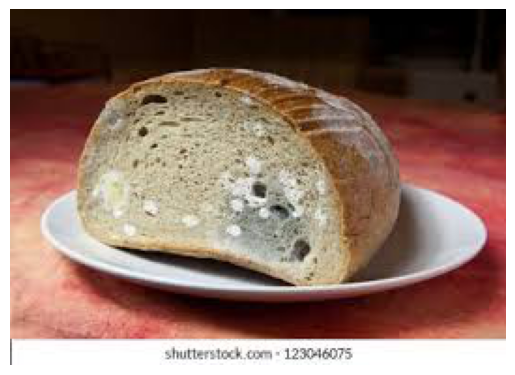

Prediksi:  biological


In [102]:
# Buka gambar
img = Image.open(image_path)

# Tampilkan gambar
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

print("Prediksi: ", result_class)

In [118]:
def load_and_preprocess_image(image_path, target_size):
    """
    Load dan preprocess gambar dari path yang diberikan.

    Args:
    image_path (str): Path ke file gambar.
    target_size (tuple): Ukuran target gambar (height, width).

    Returns:
    tf.Tensor: Tensor gambar yang telah diproses.
    """
    image = Image.open(image_path)
    image = image.resize(target_size)
    image = np.expand_dims(image, axis=0)  # Tambahkan dimensi batch
    return tf.constant(image, dtype=tf.float32)

def predict_folder(model, folder_path, target_size=(224, 224)):
    """
    Melakukan prediksi pada semua gambar dalam folder yang diberikan.

    Args:
    model (tf.saved_model): Model TensorFlow yang sudah di-load.
    folder_path (str): Path ke folder yang berisi gambar.
    target_size (tuple): Ukuran target gambar (height, width) untuk preprocess.

    Returns:
    list: Daftar hasil prediksi dengan format (filename, predicted_class, confidence).
    """
    results = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)
            image_tensor = load_and_preprocess_image(image_path, target_size)
            predicted_class, confidence = predict_with_logit_confidence(model, image_tensor)
            results.append((filename, predicted_class, confidence))
    
    return results

In [121]:
# Contoh penggunaan fungsi
folder_path = 'Unseen Data/'  # Ganti dengan path folder
results = predict_folder(infer, folder_path)

In [122]:
# Menampilkan hasil prediksi
for filename, predicted_class, confidence in results:
    print(f'File: {filename} | Predicted class: {predicted_class}: {map_labels[predicted_class]} | Confidence Score: {confidence:.4f}')

File: 01. Cardboard.jpg | Predicted class: 3: cardboard | Confidence Score: 1.0000
File: 02. Battery.jpg | Predicted class: 0: battery | Confidence Score: 0.9989
File: 03. biological.jpeg | Predicted class: 1: biological | Confidence Score: 1.0000
File: 04. brown-glass.jpg | Predicted class: 2: brown-glass | Confidence Score: 1.0000
File: 05. clothes.jpg | Predicted class: 4: clothes | Confidence Score: 1.0000
File: 06. green-glass.jpg | Predicted class: 5: green-glass | Confidence Score: 1.0000
File: 07. metal.jpg | Predicted class: 0: battery | Confidence Score: 0.9516
File: 08. paper.jpg | Predicted class: 10: trash | Confidence Score: 0.6291
File: 09. plastic.jpg | Predicted class: 8: plastic | Confidence Score: 0.9971
File: 10. shoes.jpg | Predicted class: 9: shoes | Confidence Score: 1.0000
File: 11. trash.jpg | Predicted class: 10: trash | Confidence Score: 0.9335
File: 12. white-glass.jpg | Predicted class: 11: white-glass | Confidence Score: 0.9973


In [113]:
def inspect_probabilities(model, image_tensor):
    predictions = model(image_tensor)
    probabilities = tf.nn.softmax(predictions['dense_3'], axis=-1).numpy()
    return probabilities

# Contoh penggunaan dengan satu gambar
image_path = 'Images Inference/clothes1139.jpg'  # Ganti dengan path gambar Anda
image_tensor = load_and_preprocess_image(image_path, [224,224])
probabilities = predict_with_logit_confidence(infer, image_tensor)

print("Probabilities:", probabilities)

Probabilities: (4, 1.0)
